In [1]:
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, GaussianNoise
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from scipy.stats import entropy
from umap import UMAP

c:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
recipes_df = pd.read_csv("full_format_recipes.csv")
bert_embeddings = np.load("sbert_embeddings.npy")
scaler = StandardScaler()
normalized_embeddings = scaler.fit_transform(bert_embeddings)
input_dim = bert_embeddings.shape[1]  

In [3]:
class CustomAutoencoder(tf.keras.Model):
    def __init__(self, input_dim, latent_dim):
        super(CustomAutoencoder, self).__init__()
        # Encoder
        self.input_noise = layers.GaussianNoise(0.05)  
        self.encoder_dense1 = layers.Dense(
            latent_dim, activation='relu', 
            kernel_regularizer=regularizers.l2(1e-4)
        )
        self.encoder_dense2 = layers.Dense(
            256, activation='relu', 
            kernel_regularizer=regularizers.l2(1e-4)
        )
        self.encoder_latent = layers.Dense(
            latent_dim, activation='relu',
            kernel_regularizer=regularizers.l1(1e-5)  
        )
        self.latent_noise = layers.GaussianNoise(0.05)
        self.latent_normalization = layers.LayerNormalization()

        # Decoder
        self.decoder_dense1 = layers.Dense(
            256, activation='relu', 
            kernel_regularizer=regularizers.l2(1e-4)
        )
        self.decoder_dense2 = layers.Dense(
            512, activation='relu', 
            kernel_regularizer=regularizers.l2(1e-4)
        )
        self.decoder_output = layers.Dense(input_dim, activation='sigmoid')

    def call(self, inputs):
        # Encoder
        x = self.input_noise(inputs)  
        x = self.encoder_dense1(x)
        skip = x  
        x = self.encoder_dense2(x)
        latent = self.encoder_latent(x)
        latent = self.latent_noise(latent)  
        latent = self.latent_normalization(latent)  
        latent = layers.add([latent, skip])  

        # Decoder
        x = self.decoder_dense1(latent)
        x = self.decoder_dense2(x)
        reconstruction = self.decoder_output(x)
        return reconstruction, latent



input_dim = normalized_embeddings.shape[1]
latent_dim = 512  
custom_autoencoder = CustomAutoencoder(input_dim=input_dim, latent_dim=latent_dim)


In [4]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3, decay_steps=10000, decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)


In [5]:
def clustering_loss(latent_embeddings, lambda_cluster=1.0):
    mean_embedding = tf.reduce_mean(latent_embeddings, axis=0)
    distances = tf.norm(latent_embeddings - mean_embedding, axis=1)
    cluster_penalty = tf.reduce_mean(distances)
    return lambda_cluster * cluster_penalty

def combined_loss(y_true, y_pred, latent_embeddings, lambda_recon=1.0, lambda_cluster=0.5):
    recon_loss = tf.reduce_mean(tf.square(y_true - y_pred))
    
    cluster_loss = clustering_loss(latent_embeddings, lambda_cluster)

    return lambda_recon * recon_loss + lambda_cluster * cluster_loss


In [6]:
@tf.function
def pretrain_step(x_batch):
    with tf.GradientTape() as tape:
        y_pred, _ = custom_autoencoder(x_batch)
        loss = tf.reduce_mean(tf.square(x_batch - y_pred))
    gradients = tape.gradient(loss, custom_autoencoder.trainable_weights)
    optimizer.apply_gradients(zip(gradients, custom_autoencoder.trainable_weights))
    return loss


In [7]:
@tf.function
def train_step(x_batch):
    with tf.GradientTape() as tape:
        y_pred, latent = custom_autoencoder(x_batch)
        loss = combined_loss(x_batch, y_pred, latent)
    gradients = tape.gradient(loss, custom_autoencoder.trainable_weights)
    optimizer.apply_gradients(zip(gradients, custom_autoencoder.trainable_weights))
    return loss


In [8]:
history = {'loss': [], 'silhouette': [], 'davies_bouldin': []}

pretrain_epochs = 5
fine_tune_epochs = 20
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices(normalized_embeddings).batch(batch_size)

print("Starting Pretraining...")
for epoch in range(pretrain_epochs):
    print(f"Pretraining Epoch {epoch + 1}/{pretrain_epochs}")
    epoch_loss = 0

    for step, x_batch in enumerate(train_dataset):
        loss = pretrain_step(x_batch)  
        epoch_loss += loss.numpy()

    avg_loss = epoch_loss / (step + 1)
    print(f"Reconstruction Loss: {avg_loss:.4f}")

print("\nStarting Fine-tuning...")
for epoch in range(fine_tune_epochs):
    print(f"Fine-tuning Epoch {epoch + 1}/{fine_tune_epochs}")
    epoch_loss = 0

    for step, x_batch in enumerate(train_dataset):
        loss = train_step(x_batch)
        epoch_loss += loss.numpy()

    latent_embeddings = custom_autoencoder(normalized_embeddings)[1].numpy()

    kmeans = KMeans(n_clusters=5, random_state=42).fit(latent_embeddings)

    unique_labels = len(set(kmeans.labels_))
    if unique_labels > 1:  
        silhouette = silhouette_score(latent_embeddings, kmeans.labels_)
        davies_bouldin = davies_bouldin_score(latent_embeddings, kmeans.labels_)
    else:
        silhouette = -1  
        davies_bouldin = float('inf')  

    avg_loss = epoch_loss / (step + 1)
    history['loss'].append(avg_loss)
    history['silhouette'].append(silhouette)
    history['davies_bouldin'].append(davies_bouldin)

    print(f"Loss: {avg_loss:.4f}, Silhouette: {silhouette:.4f}, DB Index: {davies_bouldin:.4f}")


Starting Pretraining...
Pretraining Epoch 1/5
Reconstruction Loss: 0.8363
Pretraining Epoch 2/5
Reconstruction Loss: 0.7054
Pretraining Epoch 3/5
Reconstruction Loss: 0.6774
Pretraining Epoch 4/5
Reconstruction Loss: 0.6638
Pretraining Epoch 5/5
Reconstruction Loss: 0.6554

Starting Fine-tuning...
Fine-tuning Epoch 1/20
Loss: 2.4189, Silhouette: 0.0489, DB Index: 5.7300
Fine-tuning Epoch 2/20
Loss: 1.1751, Silhouette: 0.1391, DB Index: 3.1346
Fine-tuning Epoch 3/20
Loss: 1.1005, Silhouette: 0.2170, DB Index: 2.0943
Fine-tuning Epoch 4/20
Loss: 1.0718, Silhouette: 0.2793, DB Index: 1.5130
Fine-tuning Epoch 5/20
Loss: 1.0579, Silhouette: 0.3434, DB Index: 1.2688
Fine-tuning Epoch 6/20
Loss: 1.0419, Silhouette: 0.3476, DB Index: 1.0606
Fine-tuning Epoch 7/20
Loss: 1.0333, Silhouette: 0.5412, DB Index: 0.8999
Fine-tuning Epoch 8/20
Loss: 1.0270, Silhouette: 0.7211, DB Index: 1.1104
Fine-tuning Epoch 9/20
Loss: 1.0205, Silhouette: 0.6582, DB Index: 0.7280
Fine-tuning Epoch 10/20
Loss: 1.016

In [9]:
reconstructions, latent_embeddings = custom_autoencoder(normalized_embeddings)
reconstructions = reconstructions.numpy()
latent_embeddings = latent_embeddings.numpy()

assert bert_embeddings.shape == reconstructions.shape, "Shape mismatch between embeddings and reconstructions!"
mse = tf.reduce_mean(tf.square(bert_embeddings - reconstructions)).numpy()
print(f"Reconstruction MSE: {mse:.4f}")


gmm = GaussianMixture(n_components=5, random_state=42)
gmm_labels = gmm.fit_predict(latent_embeddings)

silhouette = silhouette_score(latent_embeddings, gmm_labels)
davies_bouldin = davies_bouldin_score(latent_embeddings, gmm_labels)
print(f"Silhouette Score (GMM): {silhouette:.4f}")
print(f"Davies-Bouldin Index (GMM): {davies_bouldin:.4f}")


Reconstruction MSE: 0.0013
Silhouette Score (GMM): 0.8494
Davies-Bouldin Index (GMM): 1.6324


In [18]:
np.save('latent_embeddings.npy', latent_embeddings)

In [10]:
latent_var = np.var(latent_embeddings, axis=0)
print(f"Latent Embeddings Variance: {latent_var}")

if np.min(latent_var) < 1e-6:
    print("Warning: Some dimensions in latent embeddings have very low variance.")
else:
    print("Latent embeddings have sufficient variance.")
cosine_sim_matrix = cosine_similarity(latent_embeddings)

np.fill_diagonal(cosine_sim_matrix, np.nan)  
avg_cosine_similarity = np.nanmean(cosine_sim_matrix)

print(f"Average Pairwise Cosine Similarity: {avg_cosine_similarity:.4f}")

Latent Embeddings Variance: [5.3963028e-08 1.9474872e-07 7.3771169e-08 4.8756142e-08 5.1132453e-08
 5.1530698e-08 5.1931455e-08 4.9333568e-08 3.6493941e-07 5.2914451e-08
 5.0478789e-08 5.1638963e-08 5.1227723e-08 4.8800764e-08 7.6127407e-08
 6.6039959e-08 4.9312106e-08 5.2741708e-08 7.8902296e-08 4.3417824e-08
 2.4204599e-07 1.7337443e-08 5.2303246e-08 4.0408329e-07 5.1458482e-08
 4.8698730e-08 2.3157681e-07 5.0148032e-08 5.1769579e-08 5.2554629e-08
 5.2868888e-08 5.2061413e-08 4.3156337e-08 1.2066305e-06 5.0919731e-08
 4.9755478e-08 4.8989527e-08 6.1771803e-05 3.8323236e-07 4.9551819e-08
 3.8931578e-08 5.0445955e-08 5.6177953e-07 4.8304027e-08 5.2550227e-08
 4.7578201e-08 4.0502037e-08 3.3416649e-07 4.4131170e-08 5.0470394e-08
 4.9230056e-08 5.0002168e-08 4.7721503e-08 5.2427598e-08 3.5721311e-07
 4.9643809e-08 4.8724129e-08 5.1115332e-08 4.9850371e-08 5.4165554e-08
 5.1181910e-08 5.0775444e-08 4.0621163e-08 5.1792874e-08 5.0481891e-08
 2.9719243e-07 8.0785767e-08 1.5771126e-07 5.1957

In [11]:
kmeans_labels = KMeans(n_clusters=5, random_state=42).fit_predict(latent_embeddings)

cluster_sizes = np.bincount(kmeans_labels)
cluster_entropy = entropy(cluster_sizes)

print(f"Cluster Entropy: {cluster_entropy:.4f}")


Cluster Entropy: 0.3299


c:\Python312\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


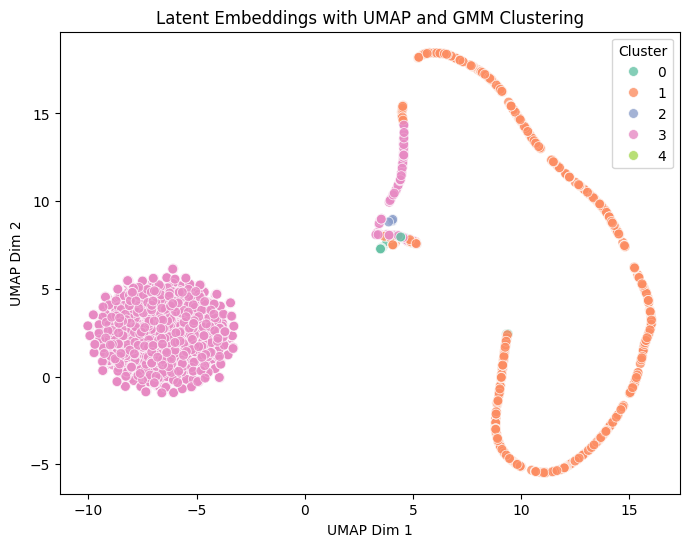

In [12]:
latent_umap = UMAP(n_components=2, random_state=42).fit_transform(latent_embeddings)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=latent_umap[:, 0], y=latent_umap[:, 1], hue=gmm_labels, palette="Set2", s=50, alpha=0.8)
plt.title("Latent Embeddings with UMAP and GMM Clustering")
plt.xlabel("UMAP Dim 1")
plt.ylabel("UMAP Dim 2")
plt.legend(title="Cluster")
plt.show()


In [13]:
def display_liked_recipes(liked_recipes):
    """
    Display the liked recipes in a table.
    """
    print("Liked Recipes:")
    display(liked_recipes.reset_index(drop=True))  


liked_recipe_indices = [76, 1669, 698]
liked_recipes = recipes_df.iloc[liked_recipe_indices][['title', 'categories', 'ingredients']]

display_liked_recipes(liked_recipes)


Liked Recipes:


,title,categories,ingredients
0,Spicy Noodles with Ginger and Fresh Vegetables,"['Garlic', 'Ginger', 'Nut', 'Pasta', 'Vegetabl...","['2 carrots, peeled', '1 large zucchini', '3 g..."
1,Parchment-Baked Sea Bass with Morels and Red W...,"['Fish', 'Mushroom', 'Bake', 'Low Fat', 'Bon A...","['1 1/2 cups bottled clam juice', '3/4 ounce d..."
2,Shepherd's Pie,"['Beef', 'Lamb', 'Potato', 'Vegetable', 'Bake'...","['10 oz pearl onions', '4 medium leeks (white ..."


In [14]:
def recommend_similar(liked_recipe_indices, latent_embeddings, top_n=5):
  
    if not isinstance(latent_embeddings, np.ndarray):
        latent_embeddings = latent_embeddings.numpy()

    liked_recipe_indices = [idx for idx in liked_recipe_indices if 0 <= idx < len(latent_embeddings)]
    if not liked_recipe_indices:
        raise ValueError("All indices in liked_recipe_indices are out of bounds.")

    print(f"Valid liked_recipe_indices: {liked_recipe_indices}")

    liked_embeddings = latent_embeddings[liked_recipe_indices]
    print(f"Liked Embeddings Shape: {liked_embeddings.shape}")

    similarity_scores = cosine_similarity(liked_embeddings, latent_embeddings)

    aggregated_scores = np.mean(similarity_scores, axis=0)

    recommended_indices = np.argsort(-aggregated_scores)
    recommended_indices = [idx for idx in recommended_indices if idx not in liked_recipe_indices][:top_n]

    return recommended_indices

In [15]:
recommended_recipes = recommend_similar(liked_recipe_indices, latent_embeddings, top_n=5)

recommended_recipes_df = recipes_df.iloc[recommended_recipes][['title', 'categories', 'ingredients']]

display_liked_recipes(recommended_recipes_df)

Valid liked_recipe_indices: [76, 1669, 698]
Liked Embeddings Shape: (3, 512)
Liked Recipes:


,title,categories,ingredients
0,Radicchio and Endive Caesar with Ciabatta Crisps,"['Salad', 'Leafy Green', 'Bake', 'Quick & Easy...","['2 tablespoons fresh lemon juice', '2 teaspoo..."
1,Ginger Spice Cookies,"['Cookies', 'Dairy', 'Egg', 'Ginger', 'Dessert...","['2 cups all purpose flour', '2 1/2 teaspoons ..."
2,Honey-Ginger Salmon,"['Ginger', 'Broil', 'Quick & Easy', 'Salmon', ...","['6 tablespoons honey', '1/4 cup chopped fresh..."
3,Cranberry-Chipotle Fruit Conserve,"['Condiment/Spread', 'Sauce', 'Side', 'Thanksg...","['1 cup pure maple syrup', '1/2 cup water', '1..."
4,Fresh Homemade Ricotta,"['Fruit Juice', 'Milk/Cream', 'Cheese', 'Citru...","['2 quarts whole milk', '1 cup heavy cream', '..."


In [16]:
custom_autoencoder.save('model/custom_autoencoder_model.keras')


In [17]:
import pickle
with open("model/scaler.pkl", "wb") as f:
    pickle.dump(scaler,f)